# Persistent Homology of Quantum Entanglement

In this notebook we first create a perturbation or generalization of a surface code, replacing the usual `CNOT` and `CZ` entangling gates with random controlled unitary gates to entangle qubits in a lattice one the surface of a torus. Once we have this, we use von Neumann entropy to measure pairwise mutual information between qubits. From this, we get a heatmap of a distance matrix which can be used for computing the $1$-parameter (the additive inverse pairwise mutual information) persistent homology. From this, we can then pass the distance matrix into something like scikit-tda. This produces persistence diagrams and barcodes that can be used to understand the local and global entanglement of a material. From this, we can study the phase transitions of topological quantum matter and other properties in condensed matter physics. 

### Persturbed Surface Code

This first code block generates a perturbed or generalized surface code circuit. 

In [1]:
import cirq
import numpy as np

# Define the qubits for the surface code
qubits = [cirq.GridQubit(i, j) for i in range(3) for j in range(3)]

def surface_code_circuit(qubits):
    """Creates a surface code circuit using controlled random unitary gates to entangle qubits"""
    code_size = int(np.sqrt(len(qubits)))
    circuit = cirq.Circuit()

    # Apply Hadamard gate to each qubit
    for q in qubits:
        circuit.append(cirq.H(q))

    # Add controlled random unitary gates to entangle qubits
    for i in range(code_size):
        for j in range(code_size):
            if i < code_size - 1:
                unitary = cirq.testing.random_unitary(2)
                circuit.append(cirq.ControlledGate(cirq.MatrixGate(unitary)).on(qubits[i*code_size+j], qubits[(i+1)*code_size+j]))
            if j < code_size - 1:
                unitary = cirq.testing.random_unitary(2)
                circuit.append(cirq.ControlledGate(cirq.MatrixGate(unitary)).on(qubits[i*code_size+j], qubits[i*code_size+j+1]))

    # Add Hadamard gates again to each qubit
    for q in qubits:
        circuit.append(cirq.H(q))

    return circuit

# Create the surface code circuit
circuit = surface_code_circuit(qubits)

# Print the circuit
print(circuit)


                                                                                                                                               ┌──────────────────────────────────────────────────────────┐                                   ┌──────────────────────────────┐
(0, 0): ───H───@───────────────────────────────@───────────────────────────────H─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                               │
               │                               ┌                         ┐
(0, 1): ───H───┼───────────────────────────────│0.056-0.067j 0.635+0.767j│─────@───────────────────────────────@────────────────────────────────H──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Distance Matrix of Pairwise Inverse Mutual Information Between Qubits

Next, we generate the heat map of the distance matrix given by the pairwise inverse mutual information between qubits. 

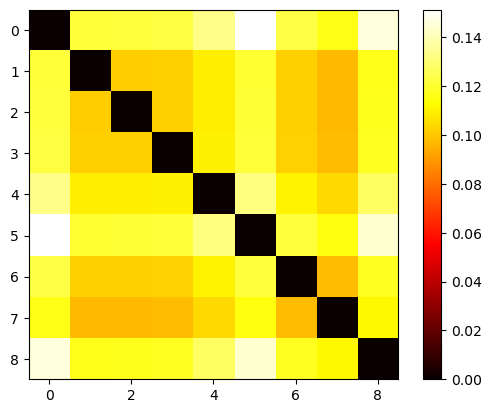

In [13]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define the qubits for the surface code
qubits = [cirq.GridQubit(i, j) for i in range(3) for j in range(3)]

def surface_code_circuit(qubits):
    """Creates a surface code circuit using controlled random unitary gates to entangle qubits"""
    code_size = int(np.sqrt(len(qubits)))
    circuit = cirq.Circuit()

    # Apply Hadamard gate to each qubit
    for q in qubits:
        circuit.append(cirq.H(q))

    # Add controlled random unitary gates to entangle qubits
    for i in range(code_size):
        for j in range(code_size):
            if i < code_size - 1:
                unitary = cirq.testing.random_unitary(2)
                circuit.append(cirq.ControlledGate(cirq.MatrixGate(unitary)).on(qubits[i*code_size+j], qubits[(i+1)*code_size+j]))
            if j < code_size - 1:
                unitary = cirq.testing.random_unitary(2)
                circuit.append(cirq.ControlledGate(cirq.MatrixGate(unitary)).on(qubits[i*code_size+j], qubits[i*code_size+j+1]))

    # Add Hadamard gates again to each qubit
    for q in qubits:
        circuit.append(cirq.H(q))

    return circuit

def compute_inverse_mutual_info(qubits):
    """Computes the inverse pairwise mutual information between each pair of qubits"""
    num_qubits = len(qubits)
    distance_matrix = np.zeros((num_qubits, num_qubits))

    # Create a surface code circuit
    circuit = surface_code_circuit(qubits)

    # Compute the final state vector of the circuit
    sim = cirq.Simulator()
    final_state = sim.simulate(circuit).state_vector()

    # Compute the marginal probability distributions for each qubit
    probs = np.abs(final_state)**2
    marginal_probs = np.sum(probs.reshape(-1, 2), axis=1)

    # Compute the inverse pairwise mutual information
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            joint_prob = np.abs(final_state)**2
            joint_probs = np.sum(joint_prob.reshape(-1, 4), axis=1)
            mutual_info = joint_probs.dot(np.log2(joint_probs/(marginal_probs[i]*marginal_probs[j])))
            distance_matrix[i,j] = distance_matrix[j,i] = 1/mutual_info

    return distance_matrix

# Compute the inverse pairwise mutual information
distance_matrix = compute_inverse_mutual_info(qubits)

# Print the distance matrix as a heat map
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


We can now apply some Topological Data Analysis to compute things like persistent homology using the [scikit-tda](https://scikit-tda.org/libraries.html) libraries. We follow the ideas of the [Persistent homology of quantum entanglement](https://arxiv.org/abs/2110.10214). The goal was to provide a complete code implementation of the ideas of this paper to study the perturbed surface codes above. This can help understand entanglement in systems using gates other than the usual `CNOT` and `CZ` gates for entangling. In particular, we might 

1. Study errors in the usual entangling gates (`CNOT`, `CZ`, etc.)
2. Design custon controlled unitaries for entangling qubits in a nonstandard way using machine learning to design th